In [74]:
import pandas as pd
import numpy as np
import jupyter_utils as ju
ju.jupyter_setup()
import os
from evaluation_and_tracking import IDPerformanceTracker
import torch
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from utils.utils import FocalLoss
pd.options.display.float_format = '{:.4f}'.format
from torch.nn import BCELoss
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import plotly.express as px

# loss_func = FocalLoss(gamma=0, exclude_outliers=0)
loss_func = BCELoss()
modalities = [
    "cough",
    "counting",
    "breath",
    "vowel"
]
modality_dict = {
    "cough":"combined_coughs",
    "counting":"combined_speech",
    "breath":"combined_breaths",
    "vowel":"combined_vowels"
}

C:\Michi\acoustic_covid_detection\python


In [75]:
# ID_PERFORMANCE_TRACKING = "noMetadataMIL_v2.pickle"
# ID_PERFORMANCE_TRACKING = "baseline_models.pickle"
ID_PERFORMANCE_TRACKING = "correct_metadata.pickle"

use_modalities = [
    "combined_coughs",
    "combined_speech",
   "combined_breaths",
   "combined_vowels"
]

In [76]:
id_performance = IDPerformanceTracker(ID_PERFORMANCE_TRACKING)
id_performance.df = id_performance.load()


# for modality in use_modalities:
id_performance.df = id_performance.df[id_performance.df.rec_type.isin(use_modalities)]

total_eval_data = id_performance.df[id_performance.df.set_type == "eval"]
total_test_data = id_performance.df[id_performance.df.set_type == "test"]

seeds = list(id_performance.df.seed.unique())
recording_types = list(total_eval_data.rec_type.unique())
print(f"Seeds used: {seeds}")
print(f"Recording Types used: {recording_types}")

# make sure, that there are even numbers for all 5 seeds, otherwise it did not record correctly
total_eval_data.seed.value_counts(), total_test_data.seed.value_counts()

Seeds used: [66445511337, 55555555, 3213213211, 215674, 99468865]
Recording Types used: ['combined_vowels', 'combined_speech', 'combined_coughs', 'combined_breaths']


(215674         1022
 55555555       1014
 3213213211     1009
 99468865        988
 66445511337     984
 Name: seed, dtype: int64,
 66445511337    1846
 55555555       1846
 3213213211     1846
 215674         1846
 99468865       1846
 Name: seed, dtype: int64)

In [77]:
df = ju.get_mean_prediction_and_loss(id_performance.df)
# df = ju.only_use_last_prediction_and_loss(id_performance)
df = ju.apply_sigmoid(df)
df

,ID,label,loss,prediction,rec_type,seed,set_type
0,01OCEf1yB4czsq8ygRoT51s96Ba2,0.0000,0.6914,0.4991,combined_vowels,66445511337,eval
1,0gB18cWHioTobGuU3qVE0QV5mBN2,0.0000,0.6826,0.4947,combined_vowels,66445511337,eval
2,0Ha52POVIxTKEPqI1eGpIoMHUd52,0.0000,0.6922,0.4995,combined_vowels,66445511337,eval
3,0HIgO2EhOOW1msCbEw1kC8Qsx6D3,0.0000,0.6835,0.4951,combined_vowels,66445511337,eval
4,0W7xMFW538WmDghkiujx2v4xVnt2,0.0000,0.6823,0.4945,combined_vowels,66445511337,eval
...,...,...,...,...,...,...,...
14242,ZNTuppbDaCNybeDYGmyjJeYr93s1,0.0000,0.7096,0.5081,combined_breaths,99468865,test
14243,zOmz0TaNdmQfF2jUFkqUKuNa80m1,0.0000,0.7047,0.5057,combined_breaths,99468865,test
14244,Zs7tQ487P7hws3ur1TG53aiF0eC2,0.0000,0.7048,0.5058,combined_breaths,99468865,test
14245,Zs8oTVcUPTc8pk9UES7sFEhRDxX2,0.0000,0.7034,0.5051,combined_breaths,99468865,test


In [78]:
full_metadata = pd.read_csv("data/Coswara_processed/full_meta_data.csv")
full_metadata = full_metadata.rename(columns={"user_id":"ID"})
for modality in modalities:
    desired_columns = [col for col in full_metadata.columns if (modality in col) and ("duration" in col) and ("trimmed" in col)]
    col_name = f"{modality_dict[modality]}_total_duration"
    full_metadata[col_name] = full_metadata[desired_columns].sum(axis=1)
desired_columns = [col for col in full_metadata.columns if ("duration" in col) and ("total" in col)]
desired_columns += ["ID", "age", "country", "gender", "type_of_covid_test"]
relevant_metadata = full_metadata[desired_columns]
merged_df = df.merge(relevant_metadata, on='ID', how='left')
merged_df

,ID,label,loss,prediction,rec_type,seed,set_type,combined_coughs_total_duration,combined_speech_total_duration,combined_breaths_total_duration,combined_vowels_total_duration,age,country,gender,type_of_covid_test
0,01OCEf1yB4czsq8ygRoT51s96Ba2,0.0000,0.6914,0.4991,combined_vowels,66445511337,eval,8.1490,24.1810,19.1470,32.2880,27,India,female,NaN
1,0gB18cWHioTobGuU3qVE0QV5mBN2,0.0000,0.6826,0.4947,combined_vowels,66445511337,eval,14.1760,23.7010,31.5950,56.5230,24,India,male,NaN
2,0Ha52POVIxTKEPqI1eGpIoMHUd52,0.0000,0.6922,0.4995,combined_vowels,66445511337,eval,5.5360,24.4910,30.7740,59.8400,22,India,female,NaN
3,0HIgO2EhOOW1msCbEw1kC8Qsx6D3,0.0000,0.6835,0.4951,combined_vowels,66445511337,eval,15.0700,22.4300,26.4480,33.6920,18,India,male,NaN
4,0W7xMFW538WmDghkiujx2v4xVnt2,0.0000,0.6823,0.4945,combined_vowels,66445511337,eval,4.4590,22.3890,26.5390,23.4340,23,India,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,ZNTuppbDaCNybeDYGmyjJeYr93s1,0.0000,0.7096,0.5081,combined_breaths,99468865,test,14.4960,22.8270,28.3740,48.9380,27,India,female,NaN
14243,zOmz0TaNdmQfF2jUFkqUKuNa80m1,0.0000,0.7047,0.5057,combined_breaths,99468865,test,5.5780,19.5630,26.4320,20.4790,29,India,male,NaN
14244,Zs7tQ487P7hws3ur1TG53aiF0eC2,0.0000,0.7048,0.5058,combined_breaths,99468865,test,9.3550,21.0780,20.8420,49.5570,23,India,male,NaN
14245,Zs8oTVcUPTc8pk9UES7sFEhRDxX2,0.0000,0.7034,0.5051,combined_breaths,99468865,test,8.7360,26.2620,25.0140,18.5600,27,India,male,NaN


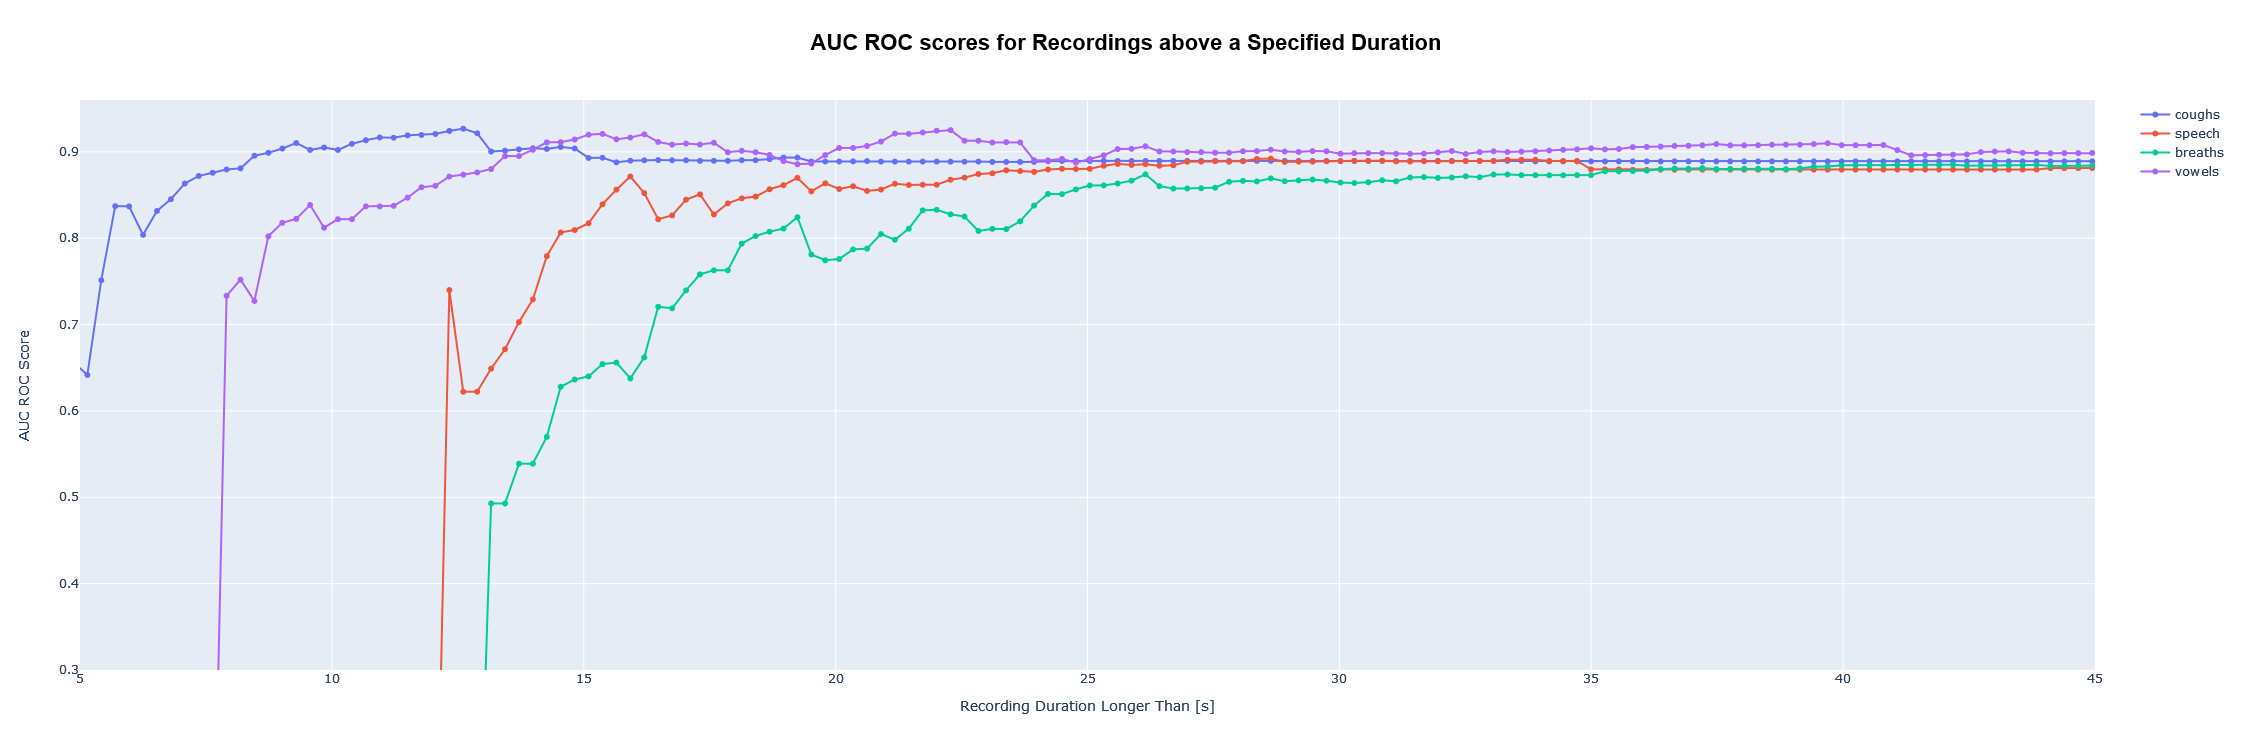

In [79]:
set_types = [
    "test",
    # "eval"
]
starting_point_sec = 1
durations = (0, starting_point_sec)
seconds = 45
time_axis = np.linspace(0, 55, 200)
fig = go.Figure()



for modality in use_modalities:
    duration_col = [col for col in full_metadata.columns if (modality in col) and ("total_duration" in col)]
    duration_col = duration_col[0]
    
    temp_df = merged_df.copy()
    metrics = []
    if len(set_types) < 2:
        temp_df = temp_df[temp_df["set_type"] == set_types[0]]
    temp_df = temp_df[temp_df["rec_type"] == modality]
    
    for offset in time_axis:
        aucroc_seeds = []
        for seed in seeds:
            df = temp_df[temp_df[duration_col] < offset]
            # df = temp_df[temp_df[duration_col] < 40]
            # df = df[df[duration_col] > offset]
            df = df[df["seed"] == seed]
            if len(df) > 10:
                aucroc_seeds.append(ju.get_aucroc(list(df.label), list(df.prediction)))
            else:
                aucroc_seeds.append(0)
                
        metrics.append(np.mean(aucroc_seeds))
        # df = temp_df[temp_df[duration_col] > durations[0]+offset]
        # df = temp_df[temp_df[duration_col] < durations[1]+offset]
        # df = temp_df[temp_df[duration_col] < offset]
        # df = temp_df[temp_df[duration_col] > offset]
        # if len(df) > 10:
            # aucroc = ju.get_aucroc(list(df.label), list(df.prediction))
            # metrics.append(aucroc)
        # else:
            # metrics.append(0)
    trace = go.Scatter(x=time_axis+starting_point_sec, y=metrics, mode='lines+markers', name=modality.replace("combined_", ""))
    fig.add_trace(trace)
layout = go.Layout(
    title={
        'text': '<b>AUC ROC scores for Recordings above a Specified Duration</b>',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='Recording Duration Longer Than [s]'),
    yaxis=dict(title='AUC ROC Score')
)
layout['height'] = 750  # You can adjust this value as needed
layout['width'] = 1500  # You can adjust this value as needed
fig.update_layout(layout)
fig.update_xaxes(range=[5, 45])  # Set the x-axis limits
fig.update_yaxes(range=[0.3, 0.96])   # Set the y-axis limits
fig.show()

In [80]:
# a version with good visualization but bad variable names is belooow

# set_types = [
#     "test",
#     "eval"
# ]

# df_visual = pd.DataFrame(columns=["gender", "modality", "values", "mean", "std", "set", "count"])


# fig = go.Figure()
# for modality in use_modalities:
#     aucroc_notest, aucroc_tested, total_aucroc = [],[],[]
#     for seed in seeds:
#         temp_df = merged_df.copy()
#         temp_df = temp_df[temp_df["seed"] == seed]
#         if len(set_types) < 2:
#             temp_df = temp_df[temp_df["set_type"] == set_types[0]]
#         temp_df = temp_df[temp_df["rec_type"] == modality]


#         df_notest = temp_df[temp_df["type_of_covid_test"] != "rtpcr"]
#         df_tested = temp_df[temp_df["type_of_covid_test"] == "rtpcr"]


#         aucroc_notest.append(ju.get_aucroc(list(df_notest.label), list(df_notest.prediction)))
#         aucroc_tested.append(ju.get_aucroc(list(df_tested.label), list(df_tested.prediction)))
#         total_aucroc.append(ju.get_aucroc(list(temp_df.label), list(temp_df.prediction)))

#         # aucroc_notest = ju.get_aucroc(list(df_notest.label), list(df_notest.prediction))
#         # aucroc_tested = ju.get_aucroc(list(df_tested.label), list(df_tested.prediction))
#         # total_aucroc = ju.get_aucroc(list(temp_df.label), list(temp_df.prediction))
#     aucroc_notest, aucroc_tested, total_aucroc = np.mean(aucroc_notest),  np.mean(aucroc_tested),  np.mean(total_aucroc)
#     print(f"modality: {modality}")
#     print(f"Datasets Used: {set_types}")
#     print(f"AUC ROC for untested Participants (count: {len(df_notest.ID.value_counts())}):   {round(aucroc_notest*100, 1)}% \nAUC ROC for tested Participants   (count: {len(df_tested.ID.value_counts())}):    {round(aucroc_tested*100,1)}%  \nAUC ROC for all Participants   (count: {len(temp_df.ID.value_counts())}):    {round(total_aucroc*100,1)}%")

In [81]:
# roc_notest = roc_curve(list(df_notest.label), list(df_notest.prediction))
# roc_tested = roc_curve(list(df_tested.label), list(df_tested.prediction))
# roc_total = roc_curve(list(temp_df.label), list(temp_df.prediction))

# tpr, fpr, _ = roc_tested
# _ = plt.plot(tpr, fpr)


In [90]:
temp = merged_df[merged_df.label > 0]
temp = temp[temp.country != "India"]
print("number of non-indian participnats with a positive label:")
len(temp.ID.value_counts())

number of non-indian participnats with a positive label:


8

In [91]:
# # "there are basicly NO (only 1-2) positive participants outside India in the validation/test set"


# set_types = [
#     "test",
#     "eval"
# ]
# fig = go.Figure()
# for modality in use_modalities:
#     aucroc_not_india, aucroc_india, total_aucroc = [],[],[]
#     for seed in seeds:
#         temp_df = merged_df.copy()
#         temp_df = temp_df[temp_df["seed"] == seed]
#         if len(set_types) < 2:
#             temp_df = temp_df[temp_df["set_type"] == set_types[0]]
#         temp_df = temp_df[temp_df["rec_type"] == modality]


#         df_non_india = temp_df[temp_df["country"] != "India"]
#         df_india = temp_df[temp_df["country"] == "India"]


#         aucroc_not_india.append(ju.get_aucroc(list(df_non_india.label), list(df_non_india.prediction)))
#         aucroc_india.append(ju.get_aucroc(list(df_india.label), list(df_india.prediction)))
#         total_aucroc.append(ju.get_aucroc(list(temp_df.label), list(temp_df.prediction)))

#     aucroc_not_india, aucroc_india, total_aucroc = np.mean(aucroc_not_india),  np.mean(aucroc_india),  np.mean(total_aucroc)
#     print(f"modality: {modality}")
#     print(f"Datasets Used: {set_types}")
#     print(f"AUC ROC for non-Indian Participants (count: {len(df_non_india.ID.value_counts())}):   {round(aucroc_not_india*100, 1)}% \nAUC ROC for Indian Participants   (count: {len(df_india.ID.value_counts())}):    {round(aucroc_india*100,1)}%  \nAUC ROC for all Participants   (count: {len(temp_df.ID.value_counts())}):    {round(total_aucroc*100,1)}%")
    
    

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\464965273.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\464965273.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\464965273.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\464965273.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\464965273.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

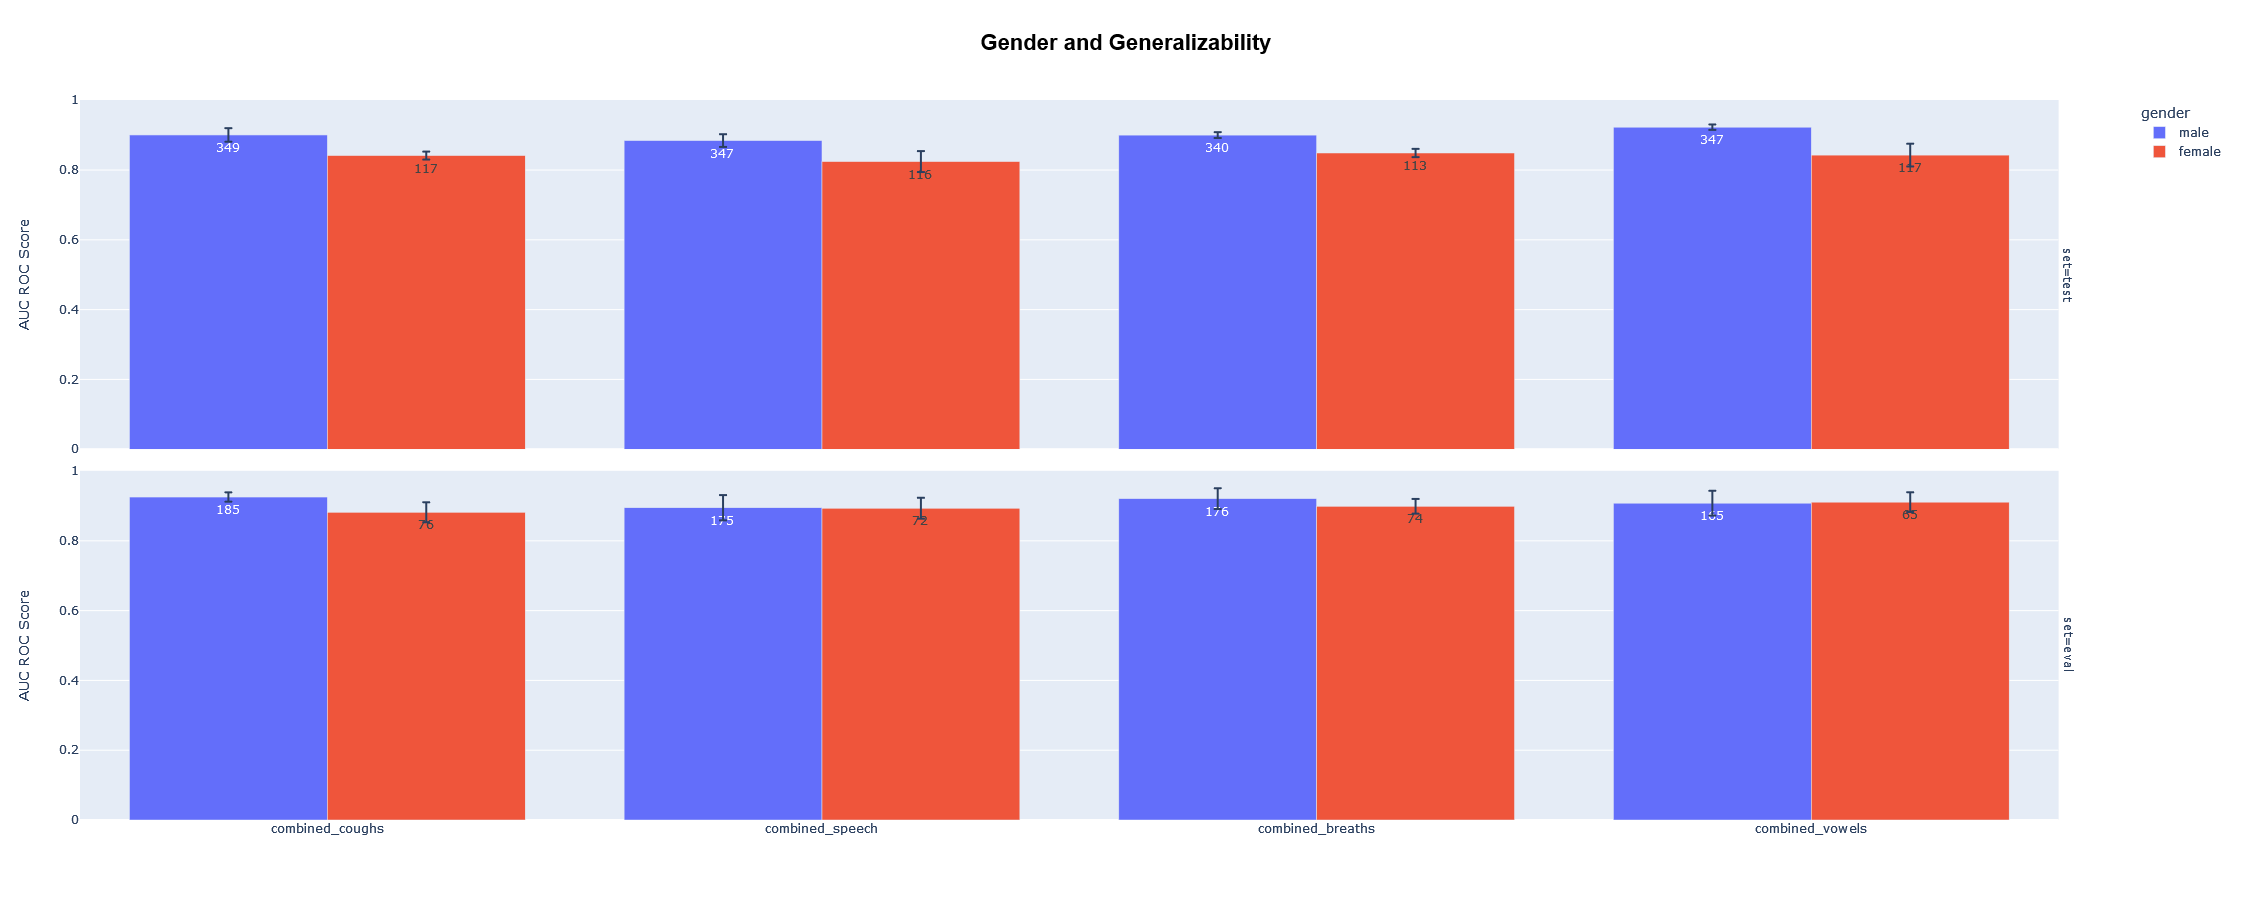

In [64]:
set_types = [
    "test",
    "eval"
]
df_visual = pd.DataFrame(columns=["gender", "modality", "values", "mean", "std", "set", "count"])


fig = go.Figure()
for set_type in set_types:
    for modality in use_modalities:
        aucroc_male, aucroc_female, total_aucroc = [],[],[]
        for seed in seeds:
            temp_df = merged_df.copy()
            temp_df = temp_df[temp_df["seed"] == seed]
            # if len(set_types) < 2:
            #     temp_df = temp_df[temp_df["set_type"] == set_types[0]]
            temp_df = temp_df[temp_df["set_type"] == set_type]
            temp_df = temp_df[temp_df["rec_type"] == modality]


            df_male = temp_df[temp_df["gender"] == "male"]
            df_female = temp_df[temp_df["gender"] == "female"]


            aucroc_male.append(ju.get_aucroc(list(df_male.label), list(df_male.prediction)))
            aucroc_female.append(ju.get_aucroc(list(df_female.label), list(df_female.prediction)))
            total_aucroc.append(ju.get_aucroc(list(temp_df.label), list(temp_df.prediction)))

        df_visual = df_visual.append({"gender": "male", "modality": modality, "values":aucroc_male,  "mean":np.mean(aucroc_male), "std":np.std(aucroc_male), "set":set_type, "count": len(df_male.ID.value_counts())}, ignore_index=True)
        df_visual = df_visual.append({"gender": "female", "modality": modality, "values":aucroc_female,  "mean":np.mean(aucroc_female), "std":np.std(aucroc_female), "set":set_type, "count": len(df_female.ID.value_counts())}, ignore_index=True)

        # aucroc_male, aucroc_female, total_aucroc = np.mean(aucroc_male),  np.mean(aucroc_female),  np.mean(total_aucroc)
        # print(f"modality: {modality}")
        # print(f"Datasets Used: {set_type}")
        # print(f"AUC ROC for male Participants (count: {len(df_male.ID.value_counts())}):   {round(aucroc_male*100, 1)}% \nAUC ROC for female Participants   (count: {len(df_female.ID.value_counts())}):    {round(aucroc_female*100,1)}%  \nAUC ROC for all Participants   (count: {len(temp_df.ID.value_counts())}):    {round(total_aucroc*100,1)}%")
fig = px.bar(df_visual, x="modality", y='mean', error_y='std', color="gender", facet_row='set', title='Mean and Std Deviation of Values per Row', barmode="group", text="count")
layout = go.Layout(
    title={
        'text': '<b>Gender and Generalizability</b>',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
        
    },
)
layout['height'] = 900  # You can adjust this value as needed
layout['width'] = 1200  # You can adjust this value as needed

subtitles = ['', '']  # Customize the subtitles here
for i, subtitle in enumerate(subtitles):
    fig.update_xaxes(title_text=subtitle, row=i+1, col=1)

fig.update_layout(layout)
fig.update_yaxes(title_text='AUC ROC Score', row=1, col=1)
fig.update_yaxes(title_text='AUC ROC Score', row=2, col=1)
fig.update_traces(textposition='inside')

fig.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\923753349.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\923753349.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\923753349.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\923753349.py:32: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\micha\AppData\Local\Temp\ipykernel_13180\923753349.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

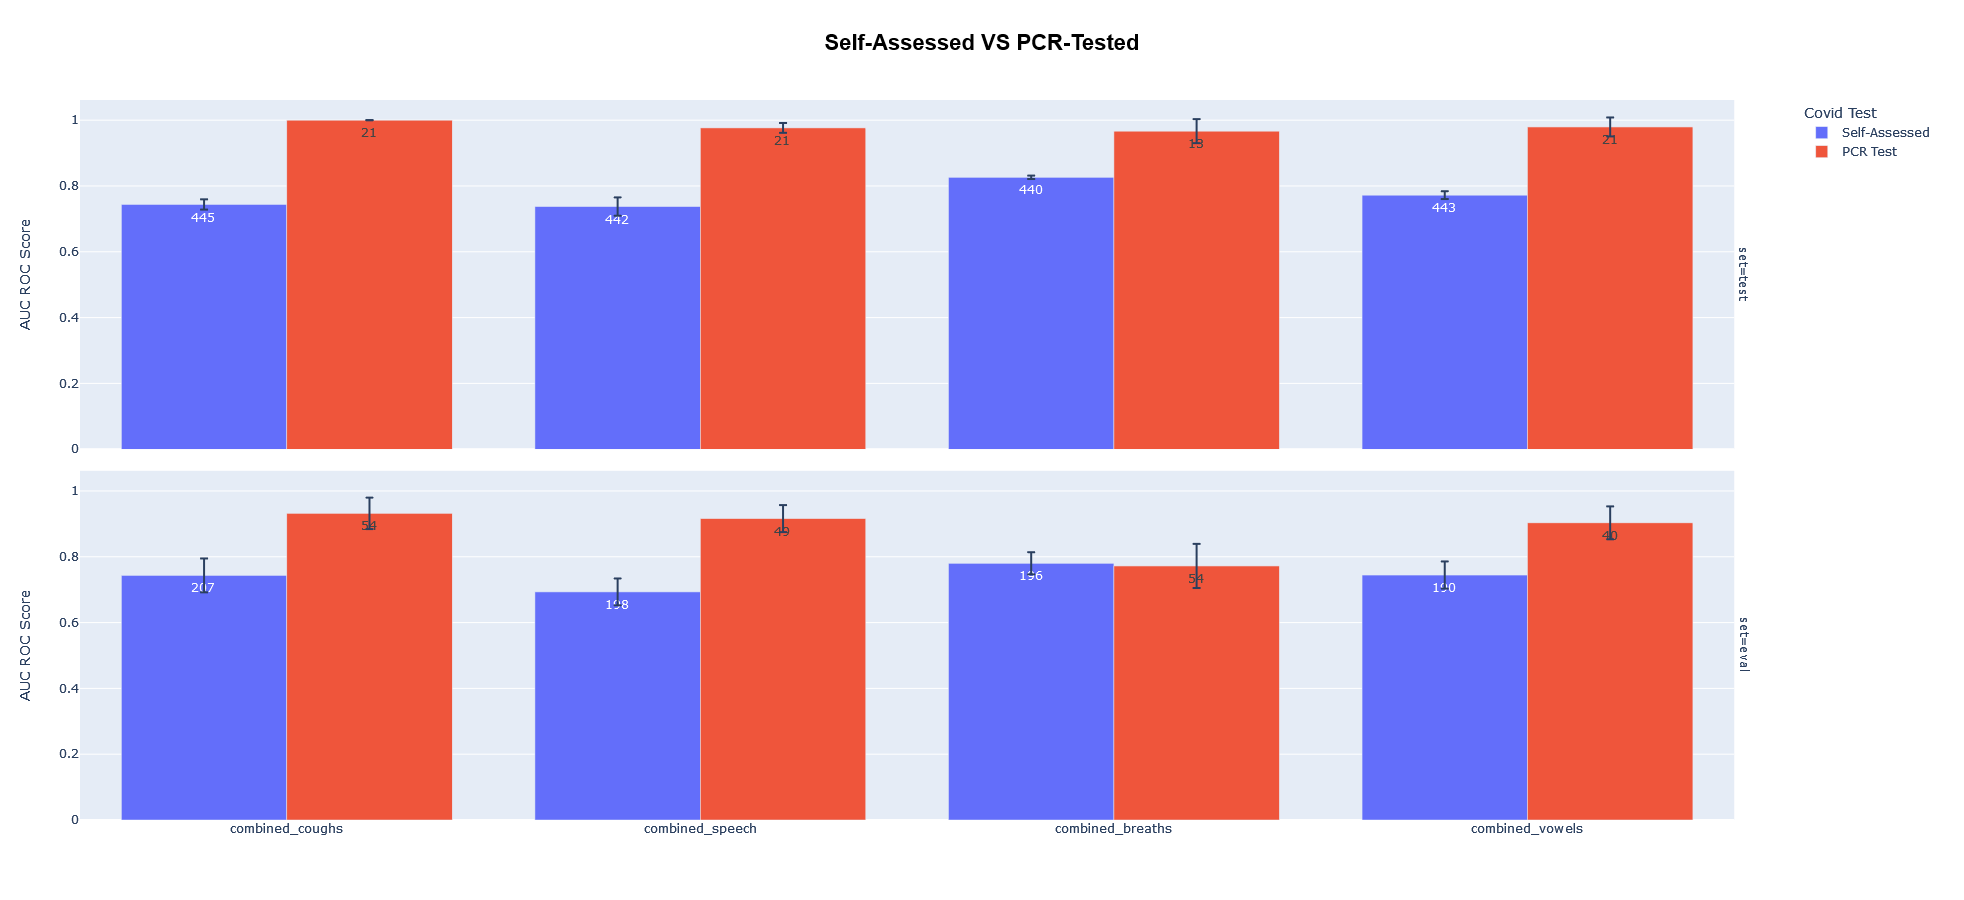

In [12]:
# quick fix for visualizing PCR tested VS self assessed - variable names are bad

set_types = [
    "test",
    "eval"
]
df_visual = pd.DataFrame(columns=["Covid Test", "modality", "values", "mean", "std", "set", "count"])


fig = go.Figure()
for set_type in set_types:
    for modality in use_modalities:
        aucroc_male, aucroc_female, total_aucroc = [],[],[]
        for seed in seeds:
            temp_df = merged_df.copy()
            temp_df = temp_df[temp_df["seed"] == seed]
            # if len(set_types) < 2:
            #     temp_df = temp_df[temp_df["set_type"] == set_types[0]]
            temp_df = temp_df[temp_df["set_type"] == set_type]
            temp_df = temp_df[temp_df["rec_type"] == modality]


            df_male = temp_df[temp_df["type_of_covid_test"] != "rtpcr"]
            df_female = temp_df[temp_df["type_of_covid_test"] == "rtpcr"]


            aucroc_male.append(ju.get_aucroc(list(df_male.label), list(df_male.prediction)))
            aucroc_female.append(ju.get_aucroc(list(df_female.label), list(df_female.prediction)))
            total_aucroc.append(ju.get_aucroc(list(temp_df.label), list(temp_df.prediction)))

        df_visual = df_visual.append({"Covid Test": "Self-Assessed", "modality": modality, "values":aucroc_male,  "mean":np.mean(aucroc_male), "std":np.std(aucroc_male), "set":set_type, "count": len(df_male.ID.value_counts())}, ignore_index=True)
        df_visual = df_visual.append({"Covid Test": "PCR Test", "modality": modality, "values":aucroc_female,  "mean":np.mean(aucroc_female), "std":np.std(aucroc_female), "set":set_type, "count": len(df_female.ID.value_counts())}, ignore_index=True)

        # aucroc_male, aucroc_female, total_aucroc = np.mean(aucroc_male),  np.mean(aucroc_female),  np.mean(total_aucroc)
        # print(f"modality: {modality}")
        # print(f"Datasets Used: {set_type}")
        # print(f"AUC ROC for male Participants (count: {len(df_male.ID.value_counts())}):   {round(aucroc_male*100, 1)}% \nAUC ROC for female Participants   (count: {len(df_female.ID.value_counts())}):    {round(aucroc_female*100,1)}%  \nAUC ROC for all Participants   (count: {len(temp_df.ID.value_counts())}):    {round(total_aucroc*100,1)}%")
fig = px.bar(df_visual, x="modality", y='mean', error_y='std', color="Covid Test", facet_row='set', title='Mean and Std Deviation of Values per Row', barmode="group", text="count")
layout = go.Layout(
    title={
        'text': '<b>Self-Assessed VS PCR-Tested</b>',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
        
    },
)
layout['height'] = 900  # You can adjust this value as needed
layout['width'] = 1200  # You can adjust this value as needed

subtitles = ['', '']  # Customize the subtitles here
for i, subtitle in enumerate(subtitles):
    fig.update_xaxes(title_text=subtitle, row=i+1, col=1)

fig.update_layout(layout)
fig.update_yaxes(title_text='AUC ROC Score', row=1, col=1)
fig.update_yaxes(title_text='AUC ROC Score', row=2, col=1)
fig.update_traces(textposition='inside')

fig.show()

In [65]:
test_df= merged_df[merged_df.set_type == "test"]
eval_df= merged_df[merged_df.set_type == "eval"]

print(test_df[test_df.gender == "female"].label.value_counts())
print(eval_df[eval_df.gender == "female"].label.value_counts())
# percentage of positive labels of women in the val and test set
print(round(410/(410+1905)*100,1), round(524/(524+994)*100, 1))
# print(test_df[test_df.gender == "male"].label.value_counts())
# print(eval_df[eval_df.gender == "male"].label.value_counts())
# percentage of positive labels of men in the val and test set
print(round(745/(745+6170)*100,1), round(742/(742+2757)*100, 1))

# print(test_df.label.value_counts())
# print(eval_df.label.value_counts())
# total ratios in test and eval set
print(round(1155/(1155+8075)*100,1), round(1266/(1266+3751)*100, 1))

0.0000    1905
1.0000     410
Name: label, dtype: int64
0.0000    994
1.0000    524
Name: label, dtype: int64
17.7 34.5
10.8 21.2
12.5 25.2


In [66]:
test_df.gender.value_counts(), eval_df.gender.value_counts()
2315/(2315+6915), 1518/(1518+3499)

(0.25081256771397614, 0.3025712577237393)

In [15]:
test_df[test_df.gender == "male"].label.value_counts(), eval_df[eval_df.gender == "male"].label.value_counts()

(0.0000    6170
 1.0000     745
 Name: label, dtype: int64,
 0.0000    2757
 1.0000     742
 Name: label, dtype: int64)

C:\Users\micha\anaconda3\envs\ai38\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

C:\Users\micha\anaconda3\envs\ai38\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

C:\Users\micha\anaconda3\envs\ai38\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

C:\Users\micha\anaconda3\envs\ai38\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

C:\Users\micha\anaconda3\envs\ai38\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

C:\Users\micha\anaconda3\envs\ai38\lib\site-packages\sklearn\metrics\_

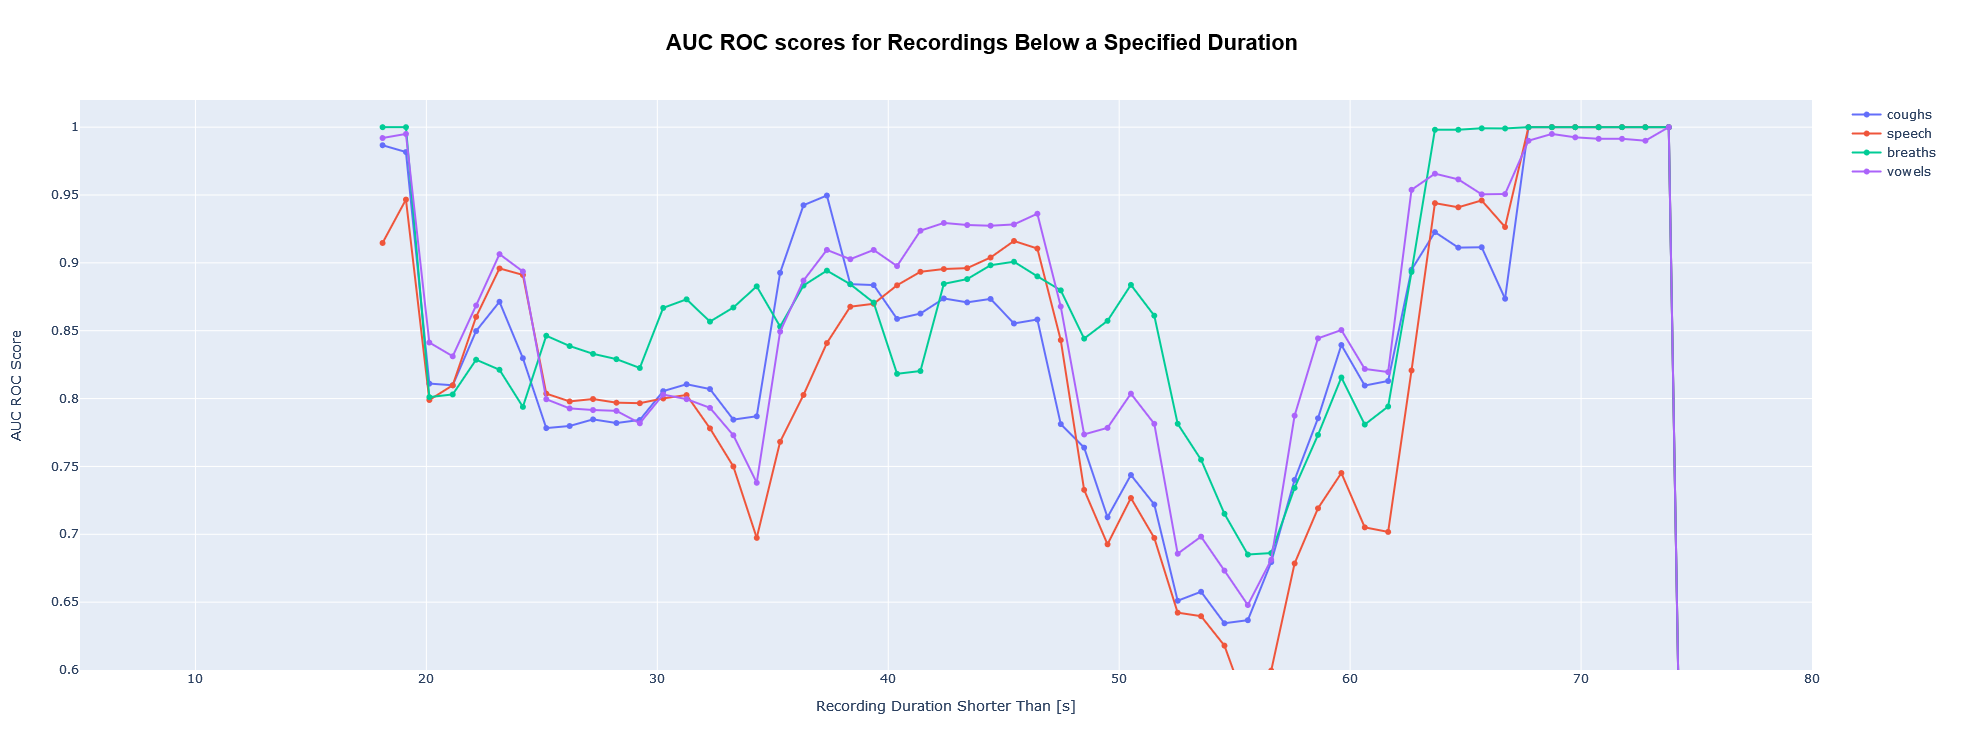

In [16]:
# todo: calculate seed wise matric and then average like above with the durations

set_types = [
    "test",
    # "eval"
]
starting_point_sec = 10
durations = (0, starting_point_sec)
seconds = 45
time_axis = np.linspace(0, 80, 80)
fig = go.Figure()
for modality in use_modalities:
    temp_df = merged_df.copy()
    metrics = []
    if len(set_types) < 2:
        temp_df = temp_df[temp_df["set_type"] == set_types[0]]
    temp_df = temp_df[temp_df["rec_type"] == modality]
    for offset in time_axis:
        duration_col = [col for col in full_metadata.columns if (modality in col) and ("total_duration" in col)]
        duration_col = duration_col[0]
        duration_col
        df = temp_df[temp_df["age"] > durations[0]+offset]
        df = df[df["age"] < durations[1]+offset]
        # df = temp_df[temp_df["age"] < offset]
        # df = temp_df[temp_df[duration_col] > offset]
        if len(df) > 15:
            aucroc = ju.get_aucroc(list(df.label), list(df.prediction))
            metrics.append(aucroc)
        else:
            metrics.append(0)
    trace = go.Scatter(x=time_axis+starting_point_sec, y=metrics, mode='lines+markers', name=modality.replace("combined_", ""))
    fig.add_trace(trace)

layout = go.Layout(
    title={
        'text': '<b>AUC ROC scores for Recordings Below a Specified Duration</b>',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='Recording Duration Shorter Than [s]'),
    yaxis=dict(title='AUC ROC Score')
)
layout['height'] = 750  # You can adjust this value as needed
layout['width'] = 1500  # You can adjust this value as needed
fig.update_layout(layout)
fig.update_xaxes(range=[5, 80])  # Set the x-axis limits
fig.update_yaxes(range=[0.6, 1.02])   # Set the y-axis limits
fig.show()

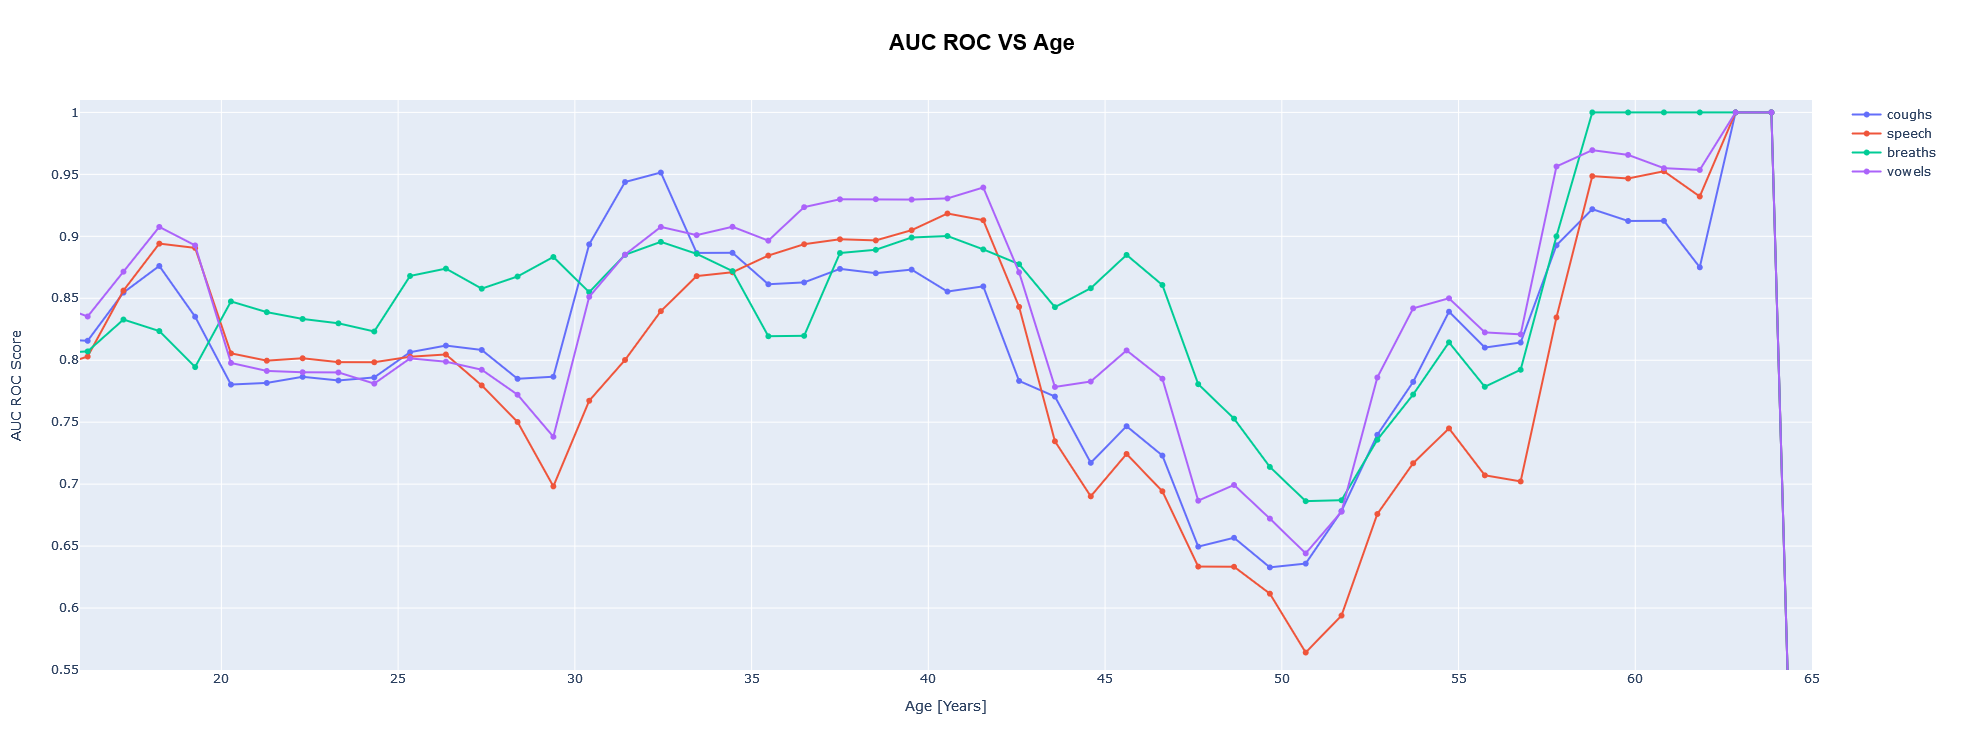

In [18]:
set_types = [
    "test",
    # "eval"
]
starting_point_sec = 5
durations = (-starting_point_sec, starting_point_sec)
seconds = 45
time_axis = np.linspace(0, 75, 75)
fig = go.Figure()



for modality in use_modalities:
    duration_col = [col for col in full_metadata.columns if (modality in col) and ("total_duration" in col)]
    duration_col = duration_col[0]
    
    temp_df = merged_df.copy()
    metrics = []
    if len(set_types) < 2:
        temp_df = temp_df[temp_df["set_type"] == set_types[0]]
    temp_df = temp_df[temp_df["rec_type"] == modality]
    
    for offset in time_axis:
        aucroc_seeds = []
        for seed in seeds:
            df = temp_df[temp_df["age"] > durations[0]+offset]
            df = df[df["age"] < durations[1]+offset]
            # df = temp_df[temp_df[duration_col] < offset]
            # df = temp_df[temp_df[duration_col] < 40]
            # df = df[df[duration_col] > offset]
            df = df[df["seed"] == seed]
            if len(df) > 10:
                aucroc_seeds.append(ju.get_aucroc(list(df.label), list(df.prediction)))
            else:
                aucroc_seeds.append(0)
                
        metrics.append(np.mean(aucroc_seeds))
        # df = temp_df[temp_df[duration_col] > durations[0]+offset]
        # df = temp_df[temp_df[duration_col] < durations[1]+offset]
        # df = temp_df[temp_df[duration_col] < offset]
        # df = temp_df[temp_df[duration_col] > offset]
        # if len(df) > 10:
            # aucroc = ju.get_aucroc(list(df.label), list(df.prediction))
            # metrics.append(aucroc)
        # else:
            # metrics.append(0)
    trace = go.Scatter(x=time_axis, y=metrics, mode='lines+markers', name=modality.replace("combined_", ""))
    fig.add_trace(trace)
layout = go.Layout(
    title={
        'text': '<b>AUC ROC VS Age</b>',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='Age [Years]'),
    yaxis=dict(title='AUC ROC Score')
)
layout['height'] = 750  # You can adjust this value as needed
layout['width'] = 1500  # You can adjust this value as needed
fig.update_layout(layout)
fig.update_xaxes(range=[16, 65])  # Set the x-axis limits
fig.update_yaxes(range=[0.55, 1.01])   # Set the y-axis limits
fig.show()

In [31]:
test_set = pd.read_csv(r"C:\Michi\acoustic_covid_detection\python\data\Coswara_processed\test_set_df_dicova.csv")
test_set["set"] = "Test Set"
dev_set = pd.read_csv(r"C:\Michi\acoustic_covid_detection\python\data\Coswara_processed\train_and_validation_set_df_dicova.csv")
dev_set["set"] = "Development Set"
combined_set = pd.concat([test_set, dev_set])


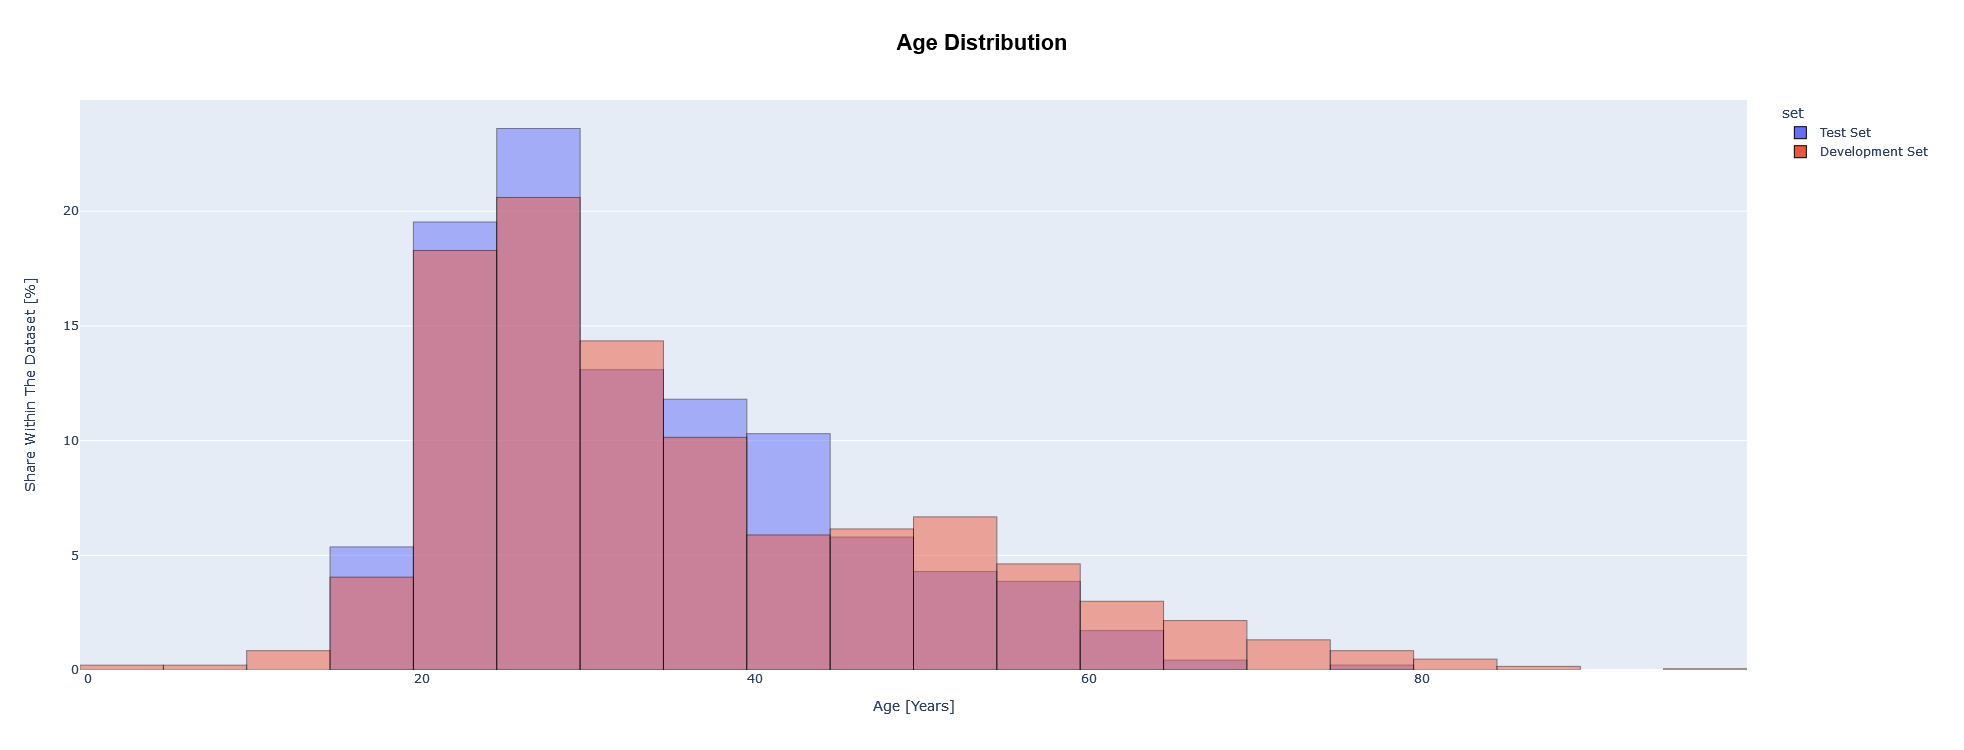

In [45]:
fig = px.histogram(combined_set, x='age', nbins=40, title='Histogram of Values', histnorm='percent', color="set", barmode='overlay')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
layout = go.Layout(
    title={
        'text': '<b>Age Distribution</b>',
        'x': 0.5,  
        'xanchor': 'center',  
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='Age [Years]'),
    yaxis=dict(title='Share Within The Dataset [%]')
)
layout['height'] = 750  
layout['width'] = 1300  
fig.update_layout(layout)
fig.show()

In [70]:
combined_set.covid_label

0      0.0000
1      0.0000
2      0.0000
3      0.0000
4      0.0000
        ...  
1898   1.0000
1899   1.0000
1900   1.0000
1901   1.0000
1902   1.0000
Name: covid_label, Length: 2369, dtype: float64

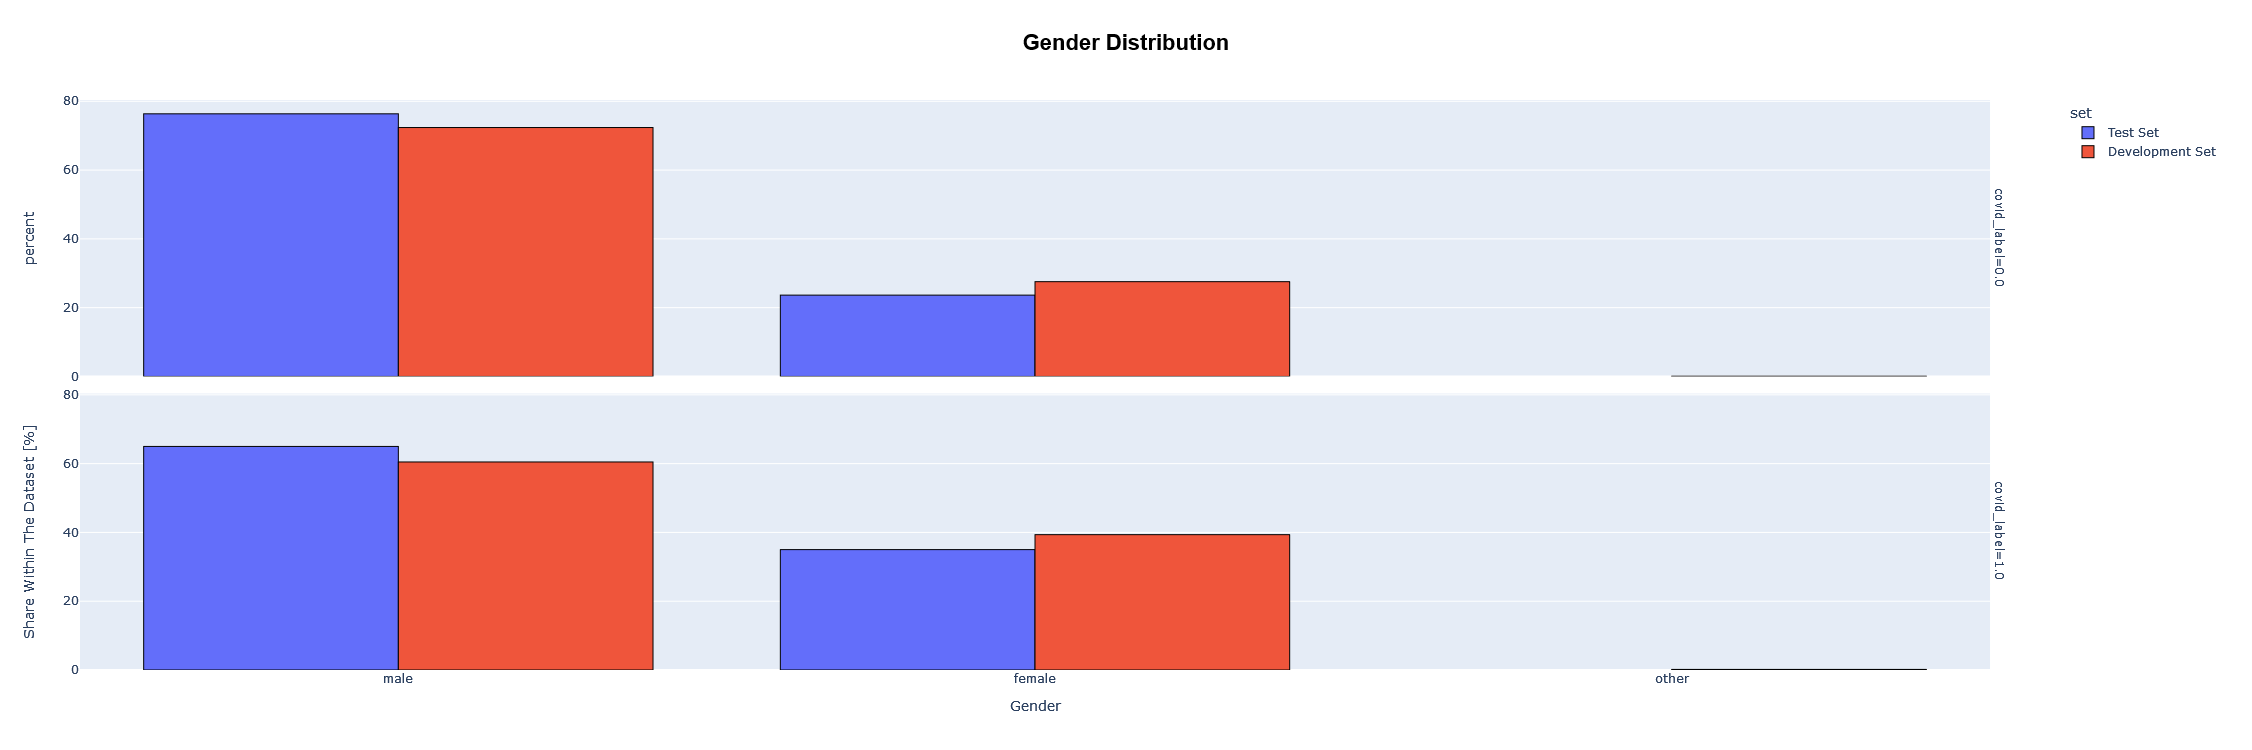

In [71]:
fig = px.histogram(combined_set, x='gender', nbins=40, title='Histogram of Values', histnorm='percent', color="set", barmode='group', facet_row='covid_label')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
layout = go.Layout(
    title={
        'text': '<b>Gender Distribution</b>',
        'x': 0.5,  
        'xanchor': 'center',  
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='Gender'),
    yaxis=dict(title='Share Within The Dataset [%]')
)
layout['height'] = 750  
layout['width'] = 1300  
fig.update_layout(layout)
fig.show()

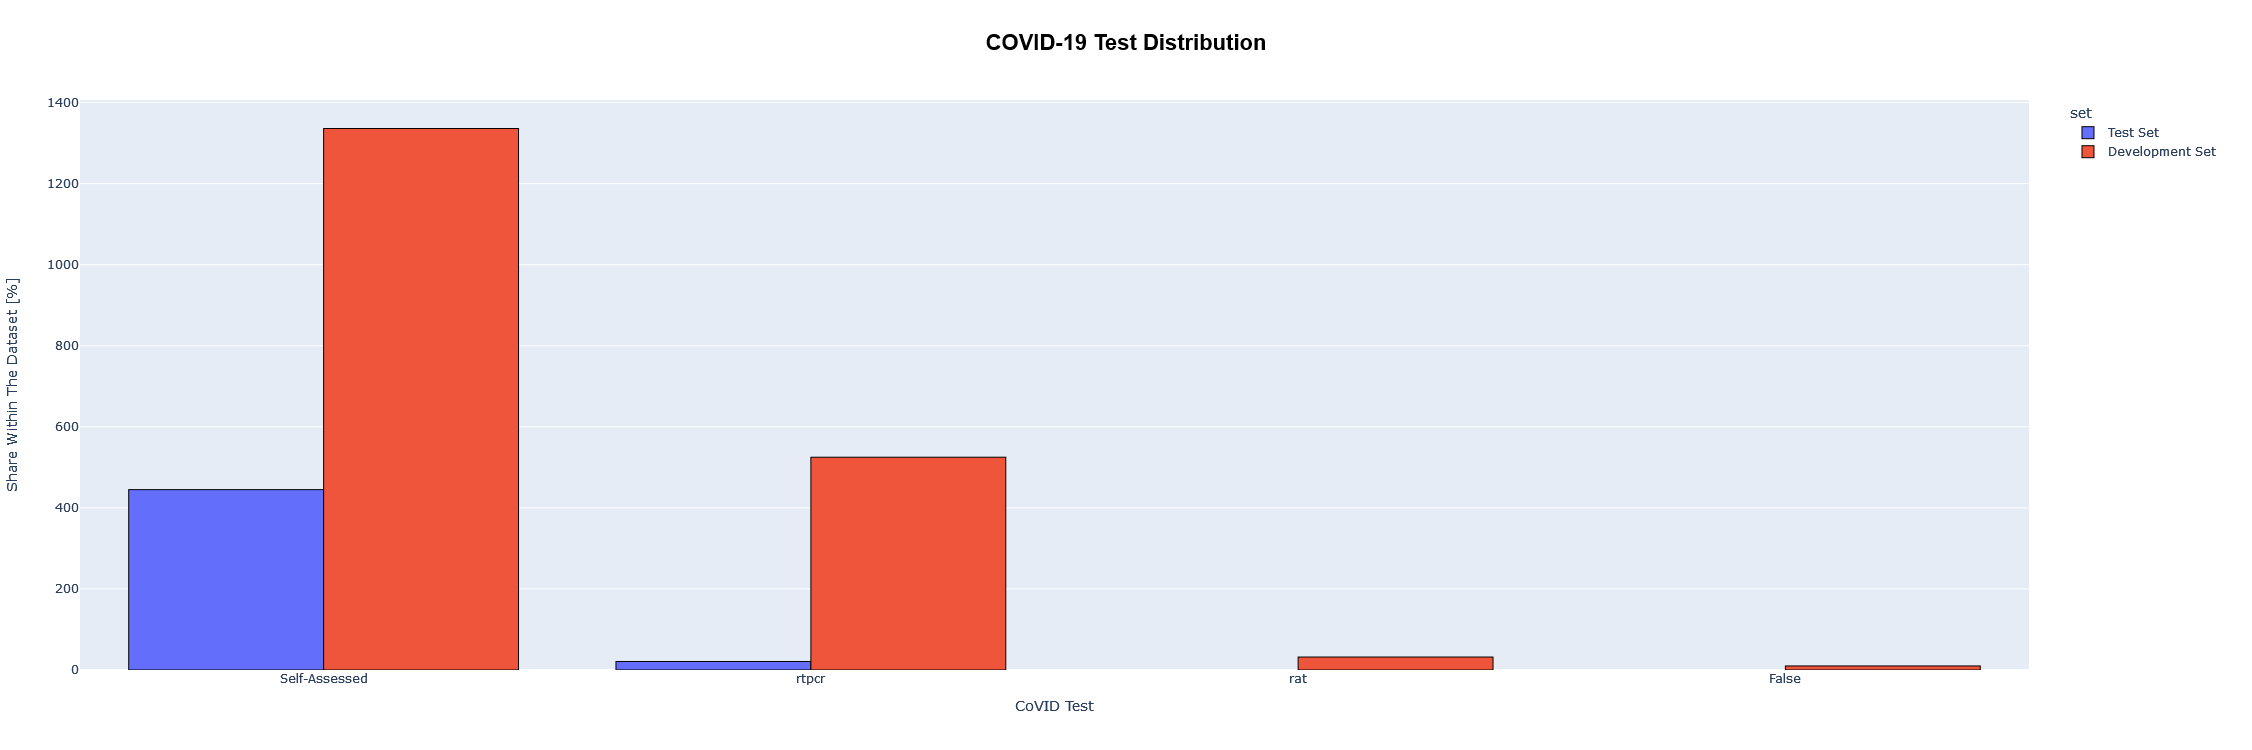

In [54]:
combined_set['type_of_covid_test'].fillna('Self-Assessed', inplace=True)
fig = px.histogram(combined_set, x='type_of_covid_test', nbins=40, title='Histogram of Values', histnorm='percent', color="set", barmode='group')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
layout = go.Layout(
    title={
        'text': '<b>COVID-19 Test Distribution</b>',
        'x': 0.5,  
        'xanchor': 'center',  
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='CoVID Test'),
    yaxis=dict(title='Share Within The Dataset [%]')
)
layout['height'] = 750  
layout['width'] = 1300  
fig.update_layout(layout)
fig.show()